In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sys

import torch 
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# custom dataset using CIFAR10 but only for cats and dogs labels
class Filtered_CIFAR10(Dataset):
  "Dataset for user specified CIFAR10 labels"
  # {'airplane': 0,
  #  'automobile': 1,
  #  'bird': 2,
  #  'cat': 3,
  #  'deer': 4,
  #  'dog': 5,
  #  'frog': 6,
  #  'horse': 7,
  #  'ship': 8,
  #  'truck': 9}
  def __init__(self, path, train=True, download=False, transform=None ,label_list=None):
    #download all dataset
    dataset = torchvision.datasets.CIFAR10(path, train=train, download=download)
    #filter cats and dogs
    if label_list is not None:
      self.label_idx , self.label_dict = self._label_to_class_idx(dataset.class_to_idx,label_list)
      self.filtered_idx = self._filtered_idx(self.label_idx, dataset.targets)
      self.data = dataset.data[self.filtered_idx,:,:,:]
      self.targets = list(np.array(dataset.targets)[self.filtered_idx])
      self.num_classes = len(label_list)
    else:
      self.data = dataset.data
      self.targets = self.targets
      self.num_clases = 10
    self.transform = transform

  def __len__(self):
    return(len(self.targets))

  def __getitem__(self,idx):
    dtype = torch.float64
    # change data from 0-255 to 0-1
    data = self.data[idx]/255
    # change from H,W,C to C,H,W
    data = data.transpose(2,0,1)
    data = torch.tensor(data, dtype = dtype)
    # apply user specified transform
    data = self.transform(data)
    # make target 1-hot encoded
    target = np.zeros(self.num_classes)
    target[self.label_dict[self.targets[idx]]] = 1
    return data, target

  @staticmethod
  def _label_to_class_idx(class_dict,label_list):
    "class idx corresponding to user specifier labels"
    label_idx=[]
    label_dict = {}
    # check all labels in dict
    i=0
    for label in label_list:
      try:
        idx = class_dict[label.lower()]
        label_idx.append(idx)
        label_dict.update({idx:i})
        i += 1
      except:
        print('undefined class labels')
        sys.exit(1)
    return label_idx , label_dict
  
  @staticmethod
  def _filtered_idx(label_idx,targets):
    "filtered data idx corresponding to user specified labels"
    data_idx = []
    label_idx = set(label_idx)
    for i,target in enumerate(targets):
      if target in label_idx:
        data_idx.append(i)
    return data_idx

In [0]:
label_list = ['cat','dog']
transform = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

train_dataset = Filtered_CIFAR10('./data_train', train=True, download=True, transform= transform, label_list=label_list)
test_dataset = Filtered_CIFAR10('./data_test', train=False, download=True, transform = transform, label_list=label_list)
batch_size = 16
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True,num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


Epoch  0:	 81514827536.3988
Epoch  1:	 11214767567.1990
Epoch  2:	 5770141100.0606
Epoch  3:	 3590820479.9326
Epoch  4:	 2479127966.0988
Epoch  5:	 1808872926.9832
Epoch  6:	 1378812413.4963
Epoch  7:	 1092123578.1894
Epoch  8:	 886562540.3722
Epoch  9:	 733746588.2170
Epoch  10:	 620112503.3308
Epoch  11:	 529536760.0050
Epoch  12:	 459693280.5462
Epoch  13:	 403491946.5748
Epoch  14:	 357834217.0710
Epoch  15:	 318687764.3942
Epoch  16:	 286381809.6080
Epoch  17:	 258954244.7105
Epoch  18:	 235853197.5573
Epoch  19:	 215248144.5002
Epoch  20:	 197928673.0861
Epoch  21:	 182067869.8589
Epoch  22:	 168844610.0453
Epoch  23:	 156489610.4199
Epoch  24:	 146111837.9976
Epoch  25:	 136270131.6445
Epoch  26:	 127751319.4348
Epoch  27:	 119682984.0561
Epoch  28:	 112518513.1023
Epoch  29:	 106293049.9317
Epoch  30:	 100206563.5180
Epoch  31:	 95058310.8921
Epoch  32:	 90170732.0365
Epoch  33:	 85573585.3073
Epoch  34:	 81683233.6101
Epoch  35:	 77663695.9653
Epoch  36:	 74160938.5090
Epoch  

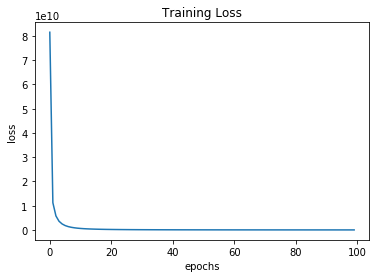

<Figure size 432x288 with 0 Axes>

In [0]:
dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
N, D_in, H1, H2, D_out = 8, 3*32*32, 1000, 256, 2
epochs = 100
# Randomly initialize weights
w1 = torch.randn(D_in, H1, device=device, dtype=dtype)
w2 = torch.randn(H1, H2, device=device, dtype=dtype)
w3 = torch.randn(H2, D_out, device=device, dtype=dtype)
learning_rate = 1e-9
loss_list = []
for epoch in range(epochs):
  running_loss= 0
  for i, data in enumerate(train_loader):
    inputs, y = data
    inputs = inputs.to(device)
    y = y.to(device)
    
    # forward prop
    x = inputs.view(batch_size,-1)
    h1 = x.mm(w1)
    h1_relu = h1.clamp(min=0)
    h2 = h1_relu.mm(w2)
    h2_relu = h2.clamp(min=0)
    y_pred = h2_relu.mm(w3)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    running_loss += loss

    y_error = y_pred - y
    # back prop
    grad_w3 = h2_relu.t().mm(2.0 * y_error)      #<<<<<< Gradient of Loss w.r.t w3
    h2_error = 2.0 * y_error.mm(w3.t())          # backpropagated error to the h2 hidden layer
    h2_error[h2 < 0] = 0                          # We set those elements of the backpropagated error
    
    grad_w2 = h1_relu.t().mm(2 * h2_error)       #<<<<<< Gradient of Loss w.r.t w2
    h1_error = 2.0 * h2_error.mm(w2.t())         # backpropagated error to the h1 hidden layer 
    h1_error[h1 < 0] = 0                          # We set those elements of the backpropagated error 

    grad_w1 = x.t().mm(2 * h1_error)             #<<<<<< Gradient of Loss w.r.t w2

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    w3 -= learning_rate * grad_w3

  print('Epoch  %d:\t %0.4f'%(epoch, running_loss))
  loss_list.append(running_loss)

# save final weights
torch.save({'w1':w1,'w2':w2,'w3':w3},'./wts.pkl')
%cp ./wts.pkl ./gdrive/My\ Drive/ECE695_DL/HW2

#plot loss
plt.plot(np.arange(epochs),loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./loss.png')
%cp ./loss.png ./gdrive/My\ Drive/ECE695_DL/HW2

In [0]:
#load wts
%cp ./gdrive/My\ Drive/ECE695_DL/HW2/wts.pkl ./
saved_wts = torch.load('./wts.pkl')
w1 = saved_wts['w1']
w2 = saved_wts['w2']
w3 = saved_wts['w3']

# Testing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
count = 0
total = 0
for i, data in enumerate(test_loader):
    inputs, y = data
    inputs = inputs.to(device)
    y = y.to(device)
    
    # forward prop
    x = inputs.view(batch_size,-1)
    h1 = x.mm(w1)
    h1_relu = h1.clamp(min=0)
    h2 = h1_relu.mm(w2)
    h2_relu = h2.clamp(min=0)
    y_pred = h2_relu.mm(w3)
    
    # # count for accuracy
    # y_pred_argmax = torch.argmax(y_pred,dim=1)
    # y_argmax = torch.argmax(y,dim=1)
    # for i_samp,sample in enumerate(y_pred_argmax):
    #   if sample ==   y_argmax[i_samp]:
    #     count += 1
    # total += batch_size

    




print('')
print('Test Accuracy:\t %0.4f%%'%(100*count/total))


Test Accuracy:	 50.4500%


In [0]:
# print to file
with open('./output.txt','w') as f:
  for i,loss in enumerate(loss_list):
    f.write('Epoch  %d:\t %0.4f\n'%(i, loss_list[i]))
  f.write('\n')
  f.write('Test Accuracy:\t %0.4f%%'%(100*count/total))

f.close()
%cp ./output.txt ./gdrive/My\ Drive/ECE695_DL/HW2

In [0]:
%cat ./output.txt

Epoch  0:	 81514827536.3988
Epoch  1:	 11214767567.1990
Epoch  2:	 5770141100.0606
Epoch  3:	 3590820479.9326
Epoch  4:	 2479127966.0988
Epoch  5:	 1808872926.9832
Epoch  6:	 1378812413.4963
Epoch  7:	 1092123578.1894
Epoch  8:	 886562540.3722
Epoch  9:	 733746588.2170
Epoch  10:	 620112503.3308
Epoch  11:	 529536760.0050
Epoch  12:	 459693280.5462
Epoch  13:	 403491946.5748
Epoch  14:	 357834217.0710
Epoch  15:	 318687764.3942
Epoch  16:	 286381809.6080
Epoch  17:	 258954244.7105
Epoch  18:	 235853197.5573
Epoch  19:	 215248144.5002
Epoch  20:	 197928673.0861
Epoch  21:	 182067869.8589
Epoch  22:	 168844610.0453
Epoch  23:	 156489610.4199
Epoch  24:	 146111837.9976
Epoch  25:	 136270131.6445
Epoch  26:	 127751319.4348
Epoch  27:	 119682984.0561
Epoch  28:	 112518513.1023
Epoch  29:	 106293049.9317
Epoch  30:	 100206563.5180
Epoch  31:	 95058310.8921
Epoch  32:	 90170732.0365
Epoch  33:	 85573585.3073
Epoch  34:	 81683233.6101
Epoch  35:	 77663695.9653
Epoch  36:	 74160938.5090
Epoch  